# Multilabel Classificator
The results obtained with the CNN models for just one label classification where is not great enough, maybe de cause of those results is that some songs are not only classify as one genre, it could be in various. Due to this  possible reason, this notebook has been created.

## Initialisation

### Libraries

In [1]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Input, Dropout, Add
from tensorflow.keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.constraints import MaxNorm
from keras.optimizers import SGD, Adam
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import os
import ast
from pathlib import Path
import matplotlib.pyplot as plt

# Import function to plot the results
!pip install seaborn
import plots

### Data Configuration Parameters
Configuration variables related to the data

In [2]:
# Randomize the initial network weights
random_seed = True

# Paths to where training, testing, and validation images are
database_dir = 'dataset_multilabel'
train_dir = f'{database_dir}/training/spectrogram'
val_dir = f'{database_dir}/val/spectrogram'
test_dir = f'{database_dir}/test/spectrogram'

# Directory where to store weights of the model and results
root_dir = "results"
# Create root directory for results if it does not exist
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

# Input dimension (number of subjects in our problem)
num_classes = 6

# Name of each gesture of the database
# CLASSES = [x for x in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, x))]
CLASSES = ['Alternative', 'Pop', 'Rock', 'Dance', 'Classical', 'Techno']
print(f'The classess to classify are: {CLASSES}')

# Parameters that characterise the spectrogram
img_height = 369
img_width = 496
img_channels = 3
color_mode = 'rgb'

The classess to classify are: ['Alternative', 'Pop', 'Rock', 'Dance', 'Classical', 'Techno']


### Configuration Training Parameters

In [3]:
# Parameters that configures the training process
batch_size = 8  # Batch size
epochs = 5  # Number of epochs
initial_lr = 1e-3   # Learning rate
seed = 42  # Random number
num_layers = 1
neu1 = 64
neu2 = 128
modelCNN = 'Random_Model'  # VGG, ResNet, Random_Model
version = ''
if num_layers == 2:
    version = f'BS{batch_size}_E{epochs}_LR{initial_lr}_Layers{num_layers}_NueronsL1{neu1}_NueronsL2{neu2}'
elif:
    version = f'BS{batch_size}_E{epochs}_LR{initial_lr}_Layers{num_layers}_NueronsL1{neu1}'
else:
    version = f'BS{batch_size}_E{epochs}_LR{initial_lr}_Layers{num_layers}_ALL
experiment_dir = f'{root_dir}/Multilabel_{modelCNN}'

# Create experiment directory if it does not exist
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

# Set random seed
np.random.seed(seed)
tf.random.set_seed(seed)

### Loading of training, validation and test datasets of images
1. Dataframes with multiabel info
2. Training dataset
3. Validation dataset
4. Test dataset

In [4]:
# Training labels
train_df = pd.read_csv(f'{database_dir}/training_multilabel.csv', delimiter='\t')
train_df['Genres']= train_df['Genres'].apply(lambda x:x.split(", "))
# train_df['Genres'] = mlb.fit_transform(train_df['Genres'])
train_df['TRACK_ID'] = train_df['TRACK_ID'].astype(str)

# Validation labels
val_df = pd.read_csv(f'{database_dir}/validation_multilabel.csv', delimiter='\t')
val_df['Genres']= val_df['Genres'].apply(lambda x:x.split(", "))
val_df['TRACK_ID'] = val_df['TRACK_ID'].astype(str)

# Test labels
test_df = pd.read_csv(f'{database_dir}/test_multilabel.csv', delimiter='\t')
test_df['Genres'] = test_df['Genres'].apply(lambda x:x.split(", "))
test_df['TRACK_ID'] = test_df['TRACK_ID'].astype(str)

In [5]:
train_generator=ImageDataGenerator().flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='TRACK_ID',
    y_col='Genres',
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode='categorical',
    classes=CLASSES,
    target_size=(img_height, img_width))

val_generator=ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    directory=val_dir,
    x_col='TRACK_ID',
    y_col='Genres',
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode='categorical',
    classes=CLASSES,
    target_size=(img_height, img_width))

test_generator=ImageDataGenerator().flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='TRACK_ID',
    y_col='Genres',
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode='categorical',
    classes=CLASSES,
    target_size=(img_height, img_width))

Found 1186 validated image filenames belonging to 6 classes.
Found 204 validated image filenames belonging to 6 classes.
Found 204 validated image filenames belonging to 6 classes.


/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 14 invalid image filename(s) in x_col="TRACK_ID". These filename(s) will be ignored.
  warnings.warn(


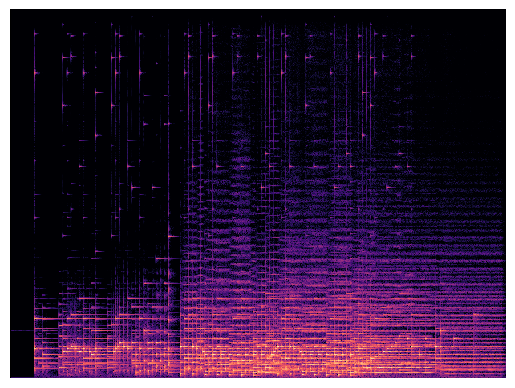

(369, 496, 3)


In [6]:
images, labels = train_generator.next()

# Muestra la primera imagen del lote
plt.imshow(images[0].astype('uint8'))
plt.axis('off')  # Desactiva los ejes
plt.show()
print(images[0].shape)

## Training process
#### Available Models: CNN

### Random model

In [7]:
def build_model(img_width,img_height,img_channels):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_width,img_height,img_channels)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    #model.add(Conv2D(64, (3, 3), padding='same'))
    #model.add(Activation('relu'))
    #model.add(Conv2D(64, (3, 3)))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    return model

### VGG-16

In [8]:
def VGG16(img_width,img_height,img_channels):
    #  dropout rate for FC layers
    dropout=0.5

    # CNN architecture
    input_image = Input(shape=(img_width,img_height,img_channels))
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(256, (1, 1),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (1, 1),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (1, 1),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Flatten()(x1)

    x=Dense(4096, activation='relu', kernel_constraint=MaxNorm(3))(x1)
    x=Dropout(dropout)(x)
    x=Dense(4096, activation='relu', kernel_constraint=MaxNorm(3))(x)
    x=Dropout(dropout)(x)
    out= Dense(num_classes, activation='softmax')(x)

    model = Model(inputs = input_image, outputs = out)

    return model

### ResNet

In [9]:
def RestNet(img_width,img_height,img_channels):
    dropout=0.5 # Para evitar que haya overfitting cancela algunas conexiones entre las neuronas aleatoriamente.

    # CNN architecture
    input_image = Input(shape=(img_width,img_height,img_channels))
    x0 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x0)
    x1 = MaxPooling2D((2, 2))(x1)
    x2 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
    x3 = Conv2D(128, (3, 3),padding='same')(x2)
    x4 = Add()([x3, x2])
    x4 = Activation('relu')(x4)
    x4 = MaxPooling2D((2, 2))(x4)
    x4 = Conv2D(256, (3, 3),padding='same', activation='relu')(x4)
    x5 = Conv2D(256, (3, 3),padding='same', activation='relu')(x4)
    x5 = Conv2D(256, (1, 1),padding='same')(x5)
    x6 = Add()([x5, x4])
    x6 = Activation('relu')(x6)
    x6 = MaxPooling2D((2, 2))(x6)
    x6 = Conv2D(512, (3, 3),padding='same', activation='relu')(x6)
    x7 = Conv2D(512, (3, 3),padding='same', activation='relu')(x6)
    x7 = Conv2D(512, (1, 1),padding='same')(x7)
    x8 = Add()([x7, x6])
    x8 = Activation('relu')(x8)
    x8 = MaxPooling2D((2, 2))(x8)
    x8 = Conv2D(512, (3, 3),padding='same', activation='relu')(x8)
    x9 = Conv2D(512, (3, 3),padding='same', activation='relu')(x8)
    x9 = Conv2D(512, (1, 1),padding='same')(x9)
    x10 = Add()([x9, x8])
    x10 = Activation('relu')(x10)
    x10 = MaxPooling2D((2, 2))(x10)
    x10 = Flatten()(x10)

    x=Dense(4096, activation='relu', kernel_constraint=MaxNorm(3))(x10)
    x=Dropout(dropout)(x)
    x=Dense(4096, activation='relu', kernel_constraint=MaxNorm(3))(x)
    x=Dropout(dropout)(x)
    out= Dense(num_classes, activation='softmax')(x)

    model = Model(inputs = input_image, outputs = out);

    return model

## Model execution

In [10]:
#Model
model = ''
if modelCNN == 'Random_Model':
    model = build_model(img_width,img_height,img_channels)
elif modelCNN == 'VGG':
    model = VGG16(img_width,img_height,img_channels)
elif modelCNN == 'ResNet':
    model = RestNet(img_width,img_height,img_channels)
else:
    print('Wrong model selection or Model no available\n')

# Print the architecture of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 496, 369, 64)      1792      
                                                                 
 activation (Activation)     (None, 496, 369, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 494, 367, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 494, 367, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 247, 183, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 247, 183, 64)      0         
                                                        

## Set model training process
#### Configuration of several training decisions:
1. Optimizer using `Adam`
2. Model training configuration using `compile` with `binary_crossentropy` due to the classification labeling

In [11]:
# 1. Configure optimizer
adam = Adam(learning_rate=initial_lr)

# 2. Configure training process
model.compile(loss = ['binary_crossentropy'],optimizer=adam, metrics=['accuracy'])

## Train the model
1. Load parameters from previous trainings if they exist.
2. Fit the model
3. Save the weights

In [12]:
# Load pretrained model
weights_path = f"weights_{version}.h5" # Name of the file to store the weights
weights_file = Path(weights_path)
weights_load_path = f'{experiment_dir}/{weights_path}'
#if weights_load_path:
#    try:
#        model.load_weights(weights_load_path)
#        print("Loaded model from {}".format(weights_load_path))
#    except:
#        print("Impossible to find weight path. Returning untrained model")

# Fit the model
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=batch_size)

# Save weights
weights_save_path = os.path.join(experiment_dir, weights_path)
model.save_weights(weights_save_path)

Epoch 1/5


2024-01-18 11:58:05.204990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-18 11:58:05.783379: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-18 11:58:06.397380: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-18 11:58:06.478295: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to a

120/149 [=======================>......] - ETA: 9s - loss: 130.5622 - accuracy: 0.2500

2024-01-18 11:58:47.061064: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-18 11:58:47.345841: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


149/149 [==============================] - ETA: 0s - loss: 105.7787 - accuracy: 0.2572

2024-01-18 11:58:59.001058: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


149/149 [==============================] - 55s 342ms/step - loss: 105.7787 - accuracy: 0.2572 - val_loss: 0.5083 - val_accuracy: 0.2990
Epoch 2/5
149/149 [==============================] - 49s 330ms/step - loss: 0.3767 - accuracy: 0.5379 - val_loss: 0.4850 - val_accuracy: 0.3137
Epoch 3/5
149/149 [==============================] - 49s 330ms/step - loss: 0.2190 - accuracy: 0.7951 - val_loss: 0.7141 - val_accuracy: 0.3235
Epoch 4/5
149/149 [==============================] - 49s 331ms/step - loss: 0.1389 - accuracy: 0.8457 - val_loss: 0.8941 - val_accuracy: 0.3186
Epoch 5/5
149/149 [==============================] - 49s 331ms/step - loss: 0.1153 - accuracy: 0.8820 - val_loss: 0.7410 - val_accuracy: 0.3529


## Training Results
Accuracy and Loss obtained along the training process

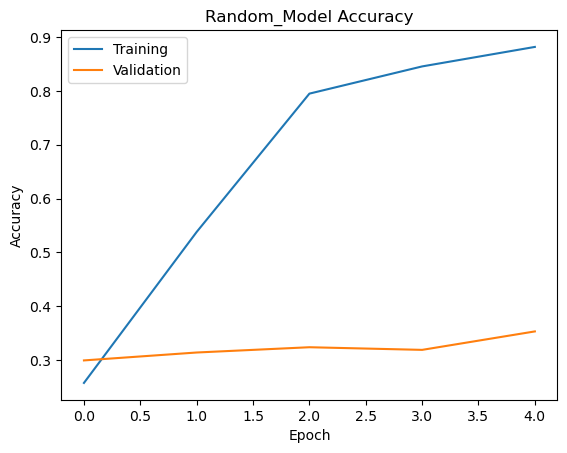

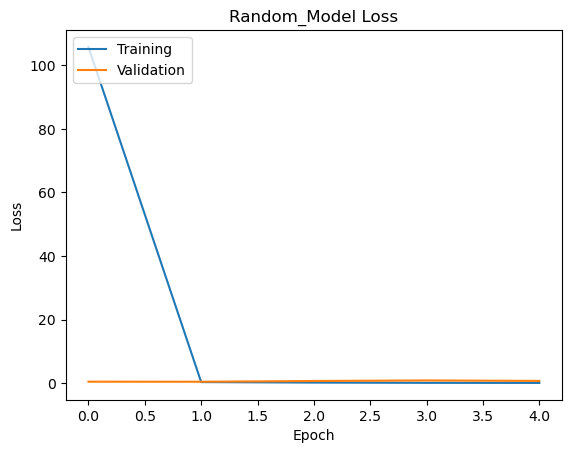

In [13]:
plots.accloss(history, modelCNN, experiment_dir, version)

## Testing
### Model Testing
1. Compute the loss function and accuracy for the test data
2. Confusion Matrix obtained from testing results

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 1 1 0]
 ...
 [0 0 0 1 1 0]
 [0 0 0 0 1 0]
 [0 0 0 1 1 0]]
Accuracy: 27.45%
Loss: 0.77
26/26 [==============================] - 2s 67ms/step
tf.Tensor(
[[0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 1 1 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]], shape=(204, 6), dtype=int32)
              precision    recall  f1-score   support

 Alternative       0.00      0.00      0.00        35
         Pop       0.57      0.62      0.59        34
        Rock       0.44      0.18      0.25        45
       Dance       0.37      0.17      0.24        58
   Classical       0.15      0.07      0.09        46
      Techno       0.00      0.00      0.00        34

   micro avg       0.40      0.17      0.24       252
   macro avg       0.26      0.17      0.20       252
weighted avg       0.27      0.17      0.20       252
 samples avg       0.19      0.18      0.18       252

Matriz de Confusión para la Clase Alternative:
 [[168   1]
 [ 35   0]]


/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


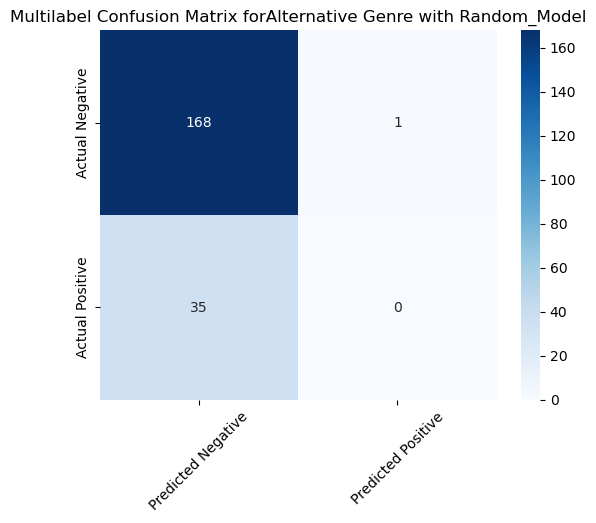

Matriz de Confusión para la Clase Pop:
 [[154  16]
 [ 13  21]]


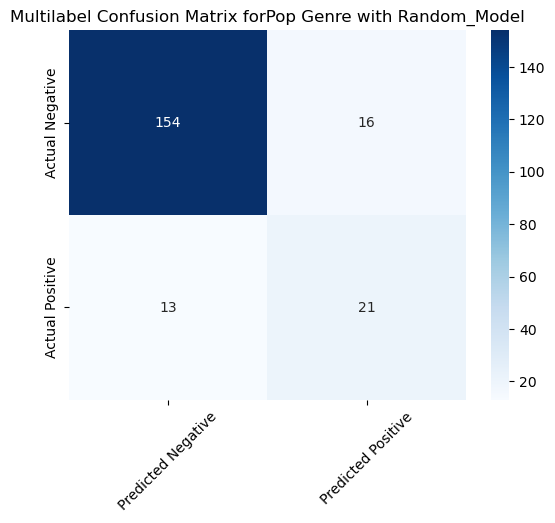

Matriz de Confusión para la Clase Rock:
 [[149  10]
 [ 37   8]]


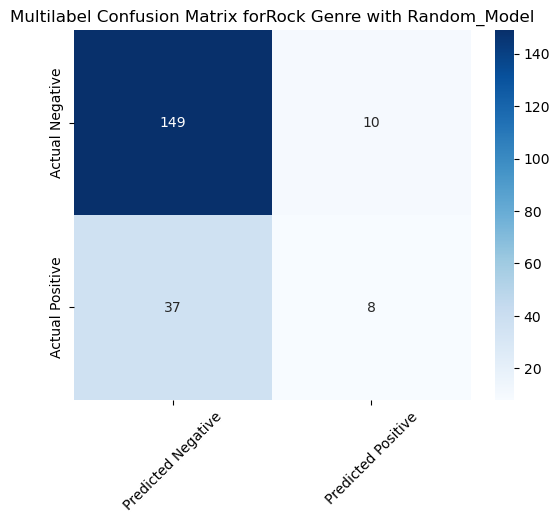

Matriz de Confusión para la Clase Dance:
 [[129  17]
 [ 48  10]]


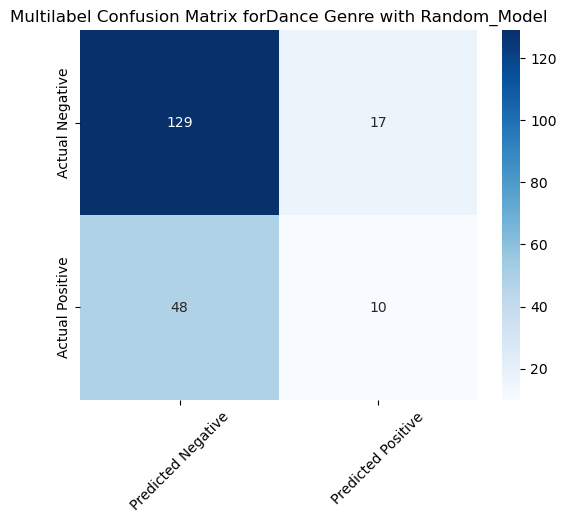

Matriz de Confusión para la Clase Classical:
 [[141  17]
 [ 43   3]]


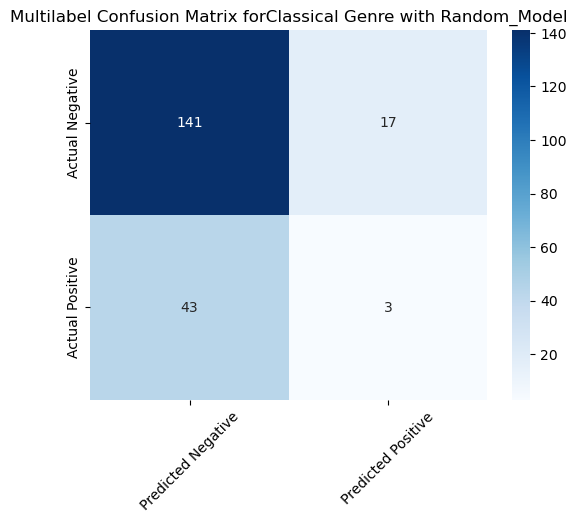

Matriz de Confusión para la Clase Techno:
 [[169   1]
 [ 34   0]]


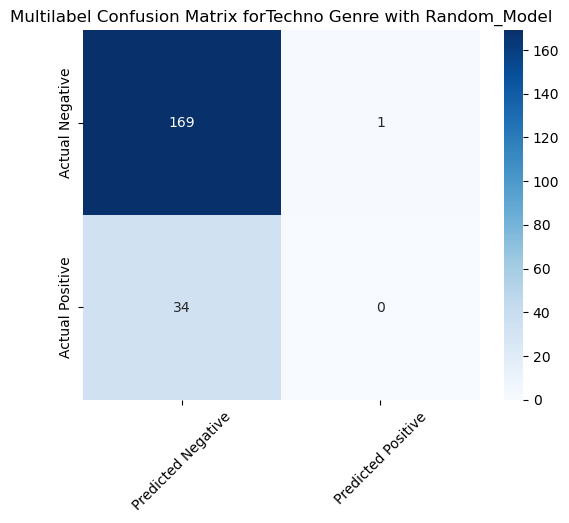

In [14]:
# y_test
mlb = MultiLabelBinarizer()
y_test = test_generator.labels
y_test = mlb.fit_transform(y_test)
print(y_test)

# Evaluate model
scores = model.evaluate(test_generator, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f" % scores[0])

# Obtain results to present the confusion matrix
prob_class = model.predict(test_generator, batch_size=batch_size)
# Convert the probabilities into binary classes
threshold = 0.5 
y_pred = tf.cast(tf.math.greater_equal(prob_class, threshold), tf.int32)
print(y_pred)
# Classification Report
report = classification_report(y_test, y_pred, output_dict=False, target_names=CLASSES)
print(report)
# Visualize confusion matrix                                           
plots.cm_mutilabel(y_test, y_pred, modelCNN, CLASSES, experiment_dir, version)